In [1]:
import os
import shutil
import glob
import subprocess
import time
import pandas as pd
import geopandas as gpd
import dask
from dask.distributed import Client, progress, LocalCluster
from pyFIRS.wrappers import lastools, fusion
from pyFIRS.utils import convert_project, PipelineError, fname, inspect_failures, processing_summary

Define where your working directory and the geographic coordinate system you're working in.

In [2]:
# where the imported lidar data is currently stored
WORKDIR = os.path.abspath('/storage/lidar/siskiyou_2017/')

# the coordinate reference system we'll be working with
TARGET_EPSG = 6339  # utm 10N, NAD83_2011
# TARGET_EPSG = 6340  # utm 11N, NAD83_2011

# Process the lidar data

Launch a parallel computing cluster. 

In [3]:
cluster = LocalCluster(scheduler_port=7001, diagnostics_port=7002)
c = Client(cluster)
num_cores = len(c.ncores())  # identify how many workers we have

/storage/anaconda3/envs/pyFIRS/lib/python3.6/site-packages/distributed/deploy/local.py:138: UserWarning: diagnostics_port has been deprecated. Please use `dashboard_address=` instead
  "diagnostics_port has been deprecated. "


At this point, you should also be able to view an interactive dashboard on port 7002. If you're executing this on a remote server, you'll need to set up port forward so you can view the dashboard on your local machine's browser. Once you've done that, or if you're processing on your own machine, you can view the dashboard at [http://localhost:7002/status](http://localhost:7002/status).

In [4]:
las = lastools.useLAStools('/storage/lidar/LAStools/bin')
fus = fusion.useFUSION('/storage/lidar/FUSION/')

In [5]:
# define data handling directories
INTERIM = os.path.join(WORKDIR, 'interim')
PROCESSED = os.path.join(WORKDIR, 'processed')

In [6]:
def log_error(tile_id, process, error_msg):
    logfile = os.path.join(INTERIM, 'failed', tile_id + '.txt')
    os.makedirs(os.path.dirname(logfile), exist_ok=True)

    with open(logfile, '+w') as f:
        f.write('{} | {}: {}'.format(tile_id, process, error_msg))

    return


def has_error(tile_id):
    errors = glob.glob(os.path.join(INTERIM, 'failed', '*.txt'))
    tiles_with_errors = [fname(error) for error in errors]
    if tile_id in tiles_with_errors:
        return True
    else:
        return False

In [7]:
strata_cols_to_grid = \
{'Total return count': 'num_returns',
 'Elev strata (below 0.15) return proportion':'strat0_return-proportion',
 'Elev strata (0.15 to 1.37) return proportion':'strat1_return-proportion',
 'Elev strata (5.00 to 10.00) return proportion':'strat2_return-proportion',
 'Elev strata (10.00 to 20.00) return proportion':'strat3_return-proportion',
 'Elev strata (20.00 to 30.00) return proportion':'strat4_return-proportion',
 'Elev strata (above 30.00) return proportion':'strat5_return-proportion',
 'Elev skewness': 'skewness',
 'Elev kurtosis': 'kurtosis',
 'Int strata (below 0.15) median':'strat0_intensity-median',
 'Int strata (0.15 to 1.37) median':'strat1_intensity-median',
 'Int strata (1.37 to 5.00) median':'strat2_intensity-median',
 'Int strata (5.00 to 10.00) median':'strat3_intensity-median',
 'Int strata (10.00 to 20.00) median':'strat4_intensity-median',
 'Int strata (above 30.00) median':'strat5_intensity-median'
}

elevation_cols_to_grid = {'Elev P05':'height_05-percentile',
                          'Elev P25':'height_25-percentile',
                          'Elev P50':'height_50-percentile',
                          'Elev P75':'height_75-percentile',
                          'Elev P95':'height_95_percentile',
                          'Elev maximum':'height_max',
                          'Percentage all returns above 1.37':'cover'}

topo_cols_to_grid = {'Elevation':'elevation',
                     'Slope (degrees)':'slope',
                     'Aspect (degrees azimuth)':'aspect',
                     'Profile curvature * 100':'profile_curvature',
                     'Plan curvature * 100':'plan_curvature',
                     'Solar Radiation Index':'solar_radiation_index',
                     'Overall Curvature':'overall_curvature'}

In [8]:
# push our working directories and wrapper classes to the workers on the cluster as well
c.scatter([INTERIM, PROCESSED, las, fus, 
           TARGET_EPSG, num_cores, has_error, log_error,
           strata_cols_to_grid, topo_cols_to_grid, elevation_cols_to_grid], 
          broadcast=True);

## Create canopy-derived rasters
Calculate forest canopy attributes using the FUSION `gridmetrics` and `gridsurfacestats` tools.

In [9]:
@dask.delayed
def make_gridmetrics(tile_id):
    infile = os.path.join(PROCESSED, 'points', tile_id + '.laz')
    groundfile = os.path.join(INTERIM, 'dtm_ground_tiles', tile_id + '.dtm')
    ODIR = os.path.join(PROCESSED, 'rasters', 'gridmetrics_tiles')
    outfile = os.path.join(ODIR, tile_id + '.csv')
    
    # get the latitude of the tile centroid
    gdf = gpd.read_file(os.path.join(INTERIM, 'tile_boundaries', tile_id+'.shp'))
    latlon = gdf.exterior.centroid.to_crs({'init':'EPSG:4326'})
    latitude = latlon.geometry.y.values[0]
    
    # get the coordinates of the lower left corner of the tile
    tile_parts = tile_id.split('_')
    if len(tile_parts) == 2:
        grid_x, grid_y = [int(coord) for coord in tile_parts]
        tile_length = 1000 # assumed tile width if not explicit in tile_id
    elif len(tile_parts) == 3:
        grid_x, grid_y, tile_length = [int(coord) for coord in tile_parts]
    
    if not os.path.exists(outfile):
        if not has_error(tile_id):
            try:
                proc = fus.gridmetrics(groundfile=groundfile,
                                       heightbreak=1.37,  # breast height (m)
                                       cellsize=10,
                                       grid=(grid_x, grid_y, tile_length, tile_length),
                                       buffer=30,
                                       outlier=(-1, 110),
                                       outputfile=outfile,
                                       datafiles=infile,
                                       strata=(0.15, 1.37, 5.0, 10.0, 20.0, 30.0),
                                       intstrata=(0.15, 1.37, 5.0, 10.0, 20.0, 30.0),
                                       las_class=(0, 1, 2, 3, 4, 5),
                                       topo=(10, latitude),
                                       odir=ODIR)
                
            except PipelineError as e:
                        log_error(tile_id, 'make_gridmetrics', e.message)
    else: # output file already exists
        pass
                
    return tile_id

In [10]:
@dask.delayed
def make_gridsurfacestats(tile_id):
    infile = os.path.join(INTERIM, 'chm_tiles', tile_id + '.dtm')
    ODIR = os.path.join(INTERIM, 'gridsurface')
    outfile = os.path.join(ODIR, tile_id + '.dtm')
    
    tile_parts = tile_id.split('_')
    if len(tile_parts) == 2:
        grid_x, grid_y = [int(coord) for coord in tile_parts]
        tile_length = 1000 # assumed tile width if not explicit in tile_id
    elif len(tile_parts) == 3:
        grid_x, grid_y, tile_length = [int(coord) for coord in tile_parts]
    
    test_output = os.path.join(ODIR, tile_id + '_max_height' + '.dtm')
    if not os.path.exists(test_output):
        if not has_error(tile_id):
            try:
                proc = fus.gridsurfacestats(
                    inputfile=infile,
                    outputfile=outfile,
                    # samplefactor describes number of cells to use in grid
                    samplefactor=20,  # 20*0.5m cells will produce 10*10m grid
                    grid=(grid_x, grid_y, tile_length, tile_length),  # clips boundary
                    asc=True,
                    odir=ODIR)
                
            except PipelineError as e:
                try:
                    log_error(tile_id, 'make_gridsurfacestats', e.message)
                except AttributeError:
                    log_error(tile_id, 'make_gridsurfacestats', e)
    else: # output file already exists
        pass
                
    return tile_id

### Convert FUSION `gridmetrics` outputs from CSV to GeoTIFF

In [11]:
def csv2grid(tile_id, csvfile, col_num, col_name):
    outfile = os.path.join(INTERIM, 'gridmetrics', 'rasters', 
                           '{}_{}.asc'.format(tile_id, col_name))
    odir = os.path.dirname(outfile)
    
    if not os.path.exists(outfile):
        if not has_error(tile_id):
            try:
                proc = fus.csv2grid(inputfile=csvfile,
                                    column=col_num,
                                    outputfile=outfile,
                                    odir=odir)
                
            except PipelineError as e:
                        log_error(tile_id, 'csv2grid', e.message)
    else: # output file already exists
        pass
                
    return tile_id

In [12]:
@dask.delayed
def batch_csv2grid(tile_id):
    GRIDMET_DIR = os.path.join(
        PROCESSED, 'rasters', 'gridmetrics_tiles')
    # read the csv containing strata data, identify the columns to extract
    strata_data = os.path.join(
        GRIDMET_DIR, tile_id + '_all_returns_strata_stats.csv')
    
    if not os.path.exists(strata_data):
        log_error(tile_id, 
                  'batch_csv2grid', 
                  '{} does not exist'.format(strata_data))
        return tile_id
    
    with open(strata_data) as f:
        header = f.readline().strip()
        cols = header.split(',')
        strata_columns = [{'col_num': cols.index(col) + 1,  # FUSION indexing starts at 1
                           'col_name': strata_cols_to_grid[col]}
                          for col in cols if col in strata_cols_to_grid.keys()]

    for col in strata_columns:
        strata_proc = csv2grid(tile_id,
                               strata_data,
                               col['col_num'],
                               col['col_name'])

    
    # read the csv containing topo data, identify the columns to extract
    topo_data = os.path.join(
        GRIDMET_DIR, tile_id + '_topo_metrics.csv')
    with open(topo_data) as f:
        header = f.readline().strip()
        cols = header.split(',')
        topo_columns = [{'col_num': cols.index(col) + 1,
                         'col_name': topo_cols_to_grid[col]}
                        for col in cols if col in topo_cols_to_grid.keys()]

    for col in topo_columns:
        topo_proc = csv2grid(tile_id,
                             topo_data,
                             col['col_num'],
                             col['col_name'])

        
    # read the csv containing elevation data, identify the columns to extract
    elevation_data = os.path.join(
        GRIDMET_DIR, tile_id + '_all_returns_elevation_stats.csv')    
    with open(elevation_data) as f:
        header = f.readline().strip()
        cols = header.split(',')
        elevation_columns = [{'col_num': cols.index(col) + 1,
                              'col_name': elevation_cols_to_grid[col]}
                             for col in cols if col in elevation_cols_to_grid.keys()]

    for col in elevation_columns:
        elev_proc = csv2grid(tile_id,
                             elevation_data,
                             col['col_num'],
                             col['col_name'])
    
    return tile_id

In [13]:
@dask.delayed
def batch_asc2tif_gridmetrics(tile_id):
    infiles = glob.glob(
        os.path.join(INTERIM, 'gridmetrics', 
                     'rasters', '{}*.asc'.format(tile_id)))
    ODIR = os.path.join(
        PROCESSED, 'rasters', 'gridmetrics_tiles')
    os.makedirs(ODIR, exist_ok=True)
    
    for infile in infiles:
        filename = fname(infile)
        outfile = os.path.join(ODIR, filename + '.tif')
    
        if not os.path.exists(outfile):
            if not has_error(tile_id):
                try:
                    convert_project(infile,
                                    outfile,
                                    'EPSG:{}'.format(TARGET_EPSG))
                except Exception as e:
                    log_error(tile_id,
                              'batch_asc2tif_gridmetrics',
                              e.message)
        else: # output file already exists
            pass
    
    return tile_id

### Convert FUSION `gridsurfacestats` outputs from ASC to GeoTIFF

In [14]:
@dask.delayed
def batch_asc2tif_gridsurface(tile_id):
    infiles = glob.glob(
        os.path.join(INTERIM, 'gridsurface', '{}*.asc'.format(tile_id)))
    ODIR = os.path.join(
        PROCESSED, 'rasters', 'gridsurface_tiles')
    os.makedirs(ODIR, exist_ok=True)
    
    for infile in infiles:
        filename = fname(infile)
        outfile = os.path.join(ODIR, filename + '.tif')
    
        if not os.path.exists(outfile):
            if not has_error(tile_id):
                try:
                    convert_project(infile,
                                    outfile,
                                    'EPSG:{}'.format(TARGET_EPSG))
                except Exception as e:
                    log_error(tile_id,
                              'batch_asc2tif_gridsurface',
                              e.message)
        else: # output file already exists
            pass
    
    return tile_id

In [15]:
@dask.delayed
def tile_done(tile_id, *args, **kwargs):
    if type(tile_id) == list:
        tile_id = tile_id[0]
        
    outfile = os.path.join(
        INTERIM, 'finished_gridmetrics', tile_id + '.txt')
    os.makedirs(os.path.dirname(outfile), exist_ok=True)
    
    if not has_error(tile_id):
        with open(outfile, '+a') as f:
            f.write('{}'.format(tile_id))
    
    return tile_id

@dask.delayed
def tiles_done(*args, **kwargs):
    return

## Identify the tiles to be processed
Account for previously-executed pipelines that have already processed some of the tiles in this acquisition.

In [16]:
tile_ids = set(fname(tile) for tile in
               glob.glob(
                   os.path.join(PROCESSED, 'points', '*.laz')))

failed_tiles = set(fname(tile) for tile in 
                   glob.glob(
                       os.path.join(INTERIM, 'failed', '*.txt')))

finished_tiles = set(fname(tile) for tile in
                     glob.glob(
                         os.path.join(INTERIM,
                                      'finished_gridmetrics',
                                      '*.txt')))

tiles_to_process = list(tile_ids - failed_tiles - finished_tiles)

print('Found {:,d} tiles to process'.format(len(tiles_to_process)))

Found 643 tiles to process


## Build the computational graph

In [17]:
dsk = {}
for tile in tiles_to_process:
    dsk['make_gridsurfacestats-{}'.format(tile)] = (
        make_gridsurfacestats,
        tile)
    dsk['make_gridmetrics-{}'.format(tile)] = (
        make_gridmetrics,
        tile)

    dsk['batch_asc2tif_gridsurface-{}'.format(tile)] = (
        batch_asc2tif_gridsurface,
        'make_gridsurfacestats-{}'.format(tile))
    dsk['batch_csv2grid-{}'.format(tile)] = (
        batch_csv2grid,
        'make_gridmetrics-{}'.format(tile))
    dsk['batch_asc2tif_gridmetrics-{}'.format(tile)] = (
        batch_asc2tif_gridmetrics,
        'batch_csv2grid-{}'.format(tile))

    dsk['tile_done-{}'.format(tile)] = (
        tile_done,
        ['batch_asc2tif_gridsurface-{}'.format(tile),
         'batch_asc2tif_gridmetrics-{}'.format(tile)])

dsk['tiles_done'] = (
    tiles_done, 
    ['tile_done-{}'.format(tile) for tile in tiles_to_process])

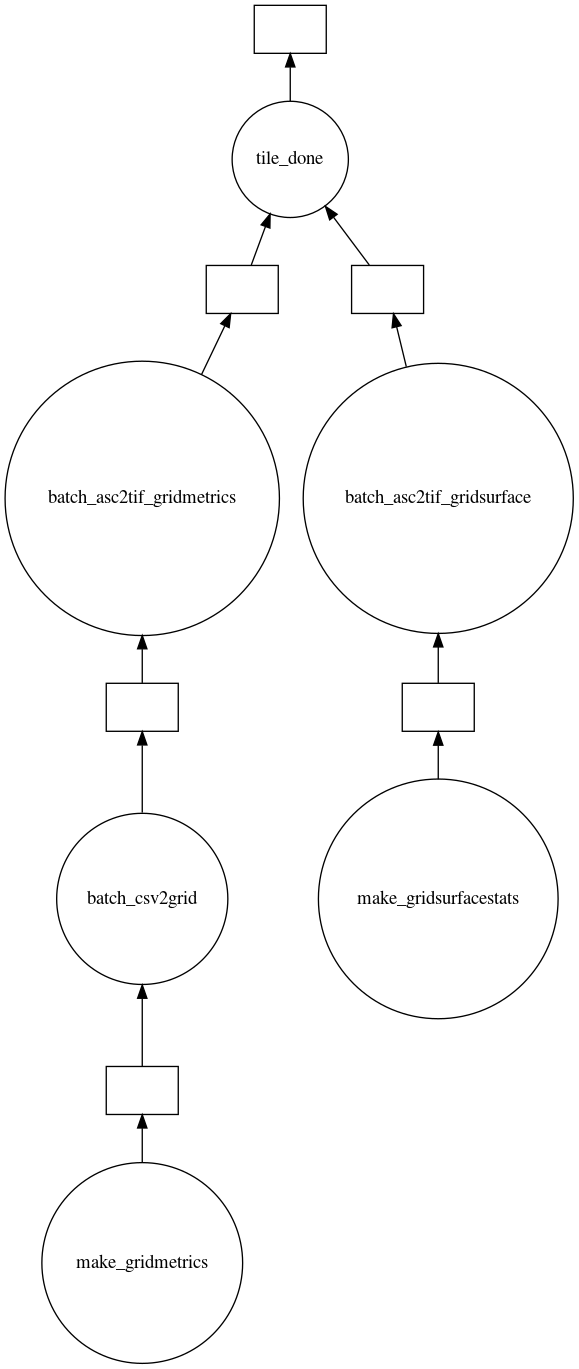

In [18]:
example_tile_graph = c.get(dsk,
                           'tile_done-{}'.format(tiles_to_process[0]))
example_tile_graph.visualize()

## Get dask to schedule the aynchronous parallel execution of the graph

In [19]:
tiles_graph = c.get(dsk, 'tiles_done')

In [20]:
tiles_results = c.persist(tiles_graph) # this might take a while...
start_time = time.time()

## Monitor the progress

In [21]:
progress(tiles_results)

VBox()

In [22]:
# c.cancel(tiles_results)

In [23]:
# tiles_results.result()

In [ ]:
processing_summary(tile_ids, finished_tiles, 
                   tiles_to_process, 
                   os.path.join(INTERIM, 'finished_gridmetrics'), 
                   os.path.join(INTERIM, 'failed'),
                   start_time)

In [ ]:
inspect_failures(os.path.join(INTERIM, 'failed'))

In [ ]:
# c.close()
# cluster.close()